<br>

<h1 style="text-align:center;">Image Captioning using BLIP</h1>

<br>

## Initial Setup

---

In [1]:
# Clone the BLIP repository
!git clone https://github.com/salesforce/BLIP.git

fatal: destination path 'BLIP' already exists and is not an empty directory.


In [2]:
# Change the directory to BLIP
import os
os.chdir("BLIP")

In [ ]:
# Import the libraries 
import tqdm
from PIL import Image
import pandas as pd
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from models.blip import blip_decoder

<br>

## Generate Caption for Image Dataset

---

In [4]:
# Use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Rename all the images in the ./../data reporsitory  
for index, filename in enumerate(os.listdir('./../../data/images/')):
    if filename.endswith(".png"):
        os.rename(f'./../../data/images/{filename}', f'./../../data/images/img ({index}).png')
    else:
        continue

In [6]:
# Set the image size
image_size = 128

In [7]:
# URL BLIP model
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'

# Load the model
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

reshape position embedding from 196 to 64
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


In [8]:
# Initialize a dataframe to store the results
results = pd.DataFrame(columns=['image', 'caption'])

# Loop through all the images in the ./../data reporsitory
for filename in tqdm.tqdm(os.listdir('./../../data/images/'), ncols=120, colour="green"):

    # Check if the file is a .png file
    if filename.endswith(".png"):

        # Open the image
        img = Image.open(f'./../../data/images/{filename}').convert('RGB')
        
        # Transform the image
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
        image = transform(img).unsqueeze(0).to(device)   

        # Generate the caption
        with torch.no_grad():
            #caption = model.generate(image, sample=False, num_beams=5, max_length=100, min_length=10)    # beam search
            caption = model.generate(image, sample=True, top_p=0.9, max_length=100, min_length=10)        # nucleus sampling

        # Append the results to the dataframe
        results = pd.concat([results, pd.DataFrame({'image': filename, 'caption': caption})], ignore_index=True)
                
    else:
        continue

# Save the results to a csv file
results.to_csv('./../../data/dataset.csv', index=False)

# Display the results
results.head()

  0%|                                                                                            | 0/96 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [00:46<00:00,  2.07it/s]


,image,caption
0,img (0).png,a demonic demon with two large swords
1,img (1).png,"a knight in purple, black and white with an el..."
2,img (2).png,a warrior with a sword in hand
3,img (3).png,an ancient lady holding two swords
4,img (4).png,the faceless king holding a sword


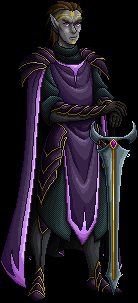

In [9]:
display(img)